# Fokker-Planck Equation II: Diffusion

This notebook looks into the integration of the diffusion term in the Fokker-Planck eqution, in the absence of Advection
Effectively, this means we will be simulating the dynamics of the equation

$$ \frac{\partial p(x, t)}{\partial t} = -D \frac{\partial^2 p(x, t)}{\partial x^2} $$

In this case, the method of solution is somewhat more complicated, as for stability we need to implement a semi-implicit scheme, in this case known as the *Crank-Nicolson* method.

In this case, for an initial distribution that is Gaussian, we should see that the distribution will spread out, and its variance should increase linearly in time $\sigma^2 \sim t$ (that is, until it interacts with a boundary condition), with proportionality related to the diffusion coefficient. We should still see and verify that normalization is preserved, and that the boundary conditions (in this case, periodic, open, and hard-wall) produce consistent results.

In [2]:
# To start, pull in the necessary imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
# the 1d integrator is contained in the Integrator module
from FPE import Integrator

# Dynamics parameters
D = 1.0
dt = 0.01
dx = 0.01
x_array = np.arange(-1, 1, dx)

# To start, initialize an integrator object
fpe = Integrator.FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="open")

# And we can, again, list the integrator attributes
fpe.__dict__.keys()



Initializing diffusion term integration matrix...

		Using Crank-Nicolson integration scheme...
		Initializing integration matrices for diffusion

		Sparse matrix methods preferred...


dict_keys(['D', 'dt', 'diffScheme', 'adScheme', 'BC', 'splitMethod', 'constDiff', 'output', 'sparseCalc', 'workAccumulator', 'workTracker', 'powerTracker', 'dx', 'N', 'prob', 'xArray', 'expImp', 'AMat', 'BMat', 'CMat'])

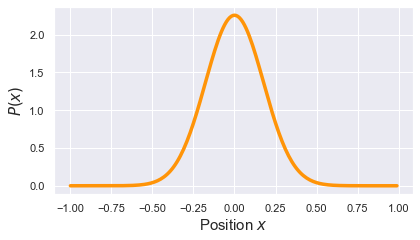

In [3]:
# Now, we can initialize the system with a Gsassian distribution using hthe build-in initializer
init_var = 1 / 32
fpe.initializeProbability(0, init_var)

# and plot the initial probably
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(fpe.xArray, fpe.prob, linewidth=3.5, color=sns.xkcd_rgb["tangerine"])
ax.set_xlabel(r"Position $x$", fontsize=15)
ax.set_ylabel(r"$P(x)$", fontsize=15)
plt.tight_layout()
plt.show()

In [4]:
# Beacuse we are working with diffusion-only, there is no CFL criterion, so we
# can just apply the diffusion algorithm to the initial distribution directly

# We initialized the system with open boundary conditions, so we should see the
# disitributions rpead out and pass through the boundaries, while the
# normalization will drop off in time
tot_time = 2.0
time = 0
counter = 0

time_tracker = [0]
density_tracker = [fpe.get_prob]

while time <= tot_time:
    fpe.diffusionUpdate()
    time += dt
    counter += 1
    if counter % 5 == 0:
        density_tracker.append(fpe.get_prob)
        time_tracker.append(time)


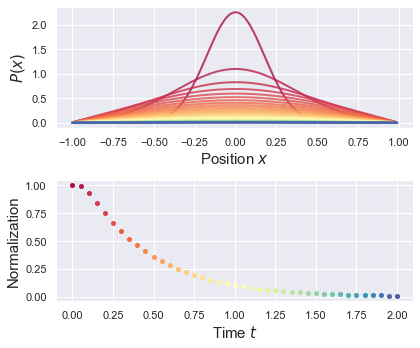

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5.0))
Pal = sns.color_palette('Spectral', len(density_tracker))

for i, density in enumerate(density_tracker):
    ax[0].plot(fpe.xArray, density, color=Pal[i], linewidth=2.0, alpha=0.8)
    ax[1].plot(time_tracker[i], np.sum(density * fpe.dx), 'o', markersize=4, color=Pal[i])

ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[0].set_ylabel(r"$P(x)$", fontsize=15)
ax[1].set_xlabel(r"Time $t$", fontsize=15)
ax[1].set_ylabel(r"Normalization", fontsize=15)
plt.tight_layout()
plt.show()



In [6]:
# Now, we can also look at hard-wall and periodic boundaries. In this case, we
# should see normalization preserved, and the system to equilibrate to a
# uniform distribution over the allowed domain

init_var = 1/64

fpe_periodic = Integrator.FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond='periodic', output=False)
fpe_hard_wall = Integrator.FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond='hard-wall', output=False)

fpe_periodic.initializeProbability(0, init_var)
fpe_hard_wall.initializeProbability(0, init_var)


In [7]:
# Now lets run the hard-wall scenario
fpe_hard_wall.initializeProbability(0, init_var)
fpe_periodic.initializeProbability(0, init_var)

total_time = 2.0
time = 0
counter = 0
density_tracker_hw = [fpe_hard_wall.get_prob]
density_tracker_per = [fpe_periodic.get_prob]
time_tracker = [time]

while time < total_time:
    fpe_hard_wall.diffusionUpdate()
    fpe_periodic.diffusionUpdate()
    counter += 1
    time += fpe_hard_wall.dt
    if counter % 5 == 0:
        density_tracker_hw.append(fpe_hard_wall.get_prob)
        density_tracker_per.append(fpe_periodic.get_prob)
        time_tracker.append(time)


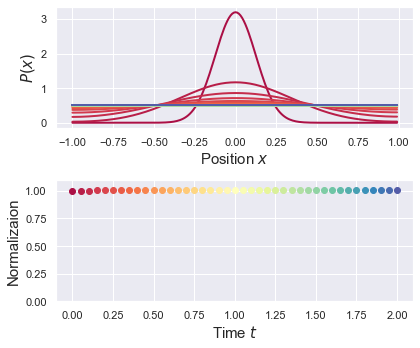

In [8]:
# First lets look at the hard-wall results
fig, ax = plt.subplots(2, 1, figsize=(6, 5))
Pal = sns.color_palette("Spectral", len(density_tracker_hw))

for i, density in enumerate(density_tracker_hw):
    ax[0].plot(x_array, density, linewidth=2.0, color=Pal[i])
    ax[1].plot(time_tracker[i], np.sum(density * dx), 'o', markersize=6, color=Pal[i])

ax[1].set_ylim([0, 1.1])
ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[0].set_ylabel(r"$P(x)$", fontsize=15)
ax[1].set_xlabel(r"Time $t$", fontsize=15)
ax[1].set_ylabel(r"Normalizaion", fontsize=15)
plt.tight_layout()
plt.show()



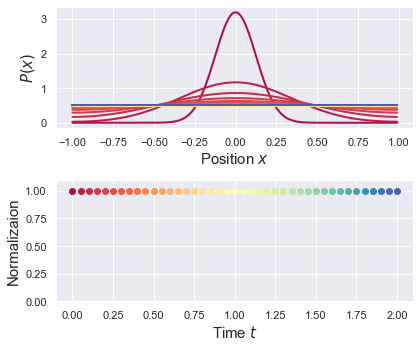

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5))
Pal = sns.color_palette("Spectral", len(density_tracker_per))

for i, density in enumerate(density_tracker_per):
    ax[0].plot(x_array, density, linewidth=2.0, color=Pal[i])
    ax[1].plot(time_tracker[i], np.sum(density * dx), 'o', markersize=6, color=Pal[i])

ax[1].set_ylim([0, 1.1])
ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[0].set_ylabel(r"$P(x)$", fontsize=15)
ax[1].set_xlabel(r"Time $t$", fontsize=15)
ax[1].set_ylabel(r"Normalizaion", fontsize=15)
plt.tight_layout()
plt.show()



So, it appears in all cases the distribution is evolving in time as we would expect, and the boundary conditions are all behaving as well. Now we want to test two things. First, the periodic and hard-wall situations look very similar in the simulations above, which is due to to symmetric of the initial distribution (it is centered about the middle of the domain). So, we can start to see differences in their behaviour if we initialize a system in a distribution that is not centered at $x = 0$. Here, the periodic system should equilibrate faster, as it will be able to diffuse over the periodic boundary, while the hard wall system can only reach tha far side of the domain by traversing the interior.  We can quantify this by tracking the deviation of the distrubution fromuniform, by calculating

$$ \text{MSD} = \frac{1}{N}\sum_{i=0}^{N-1} \left( p_i - \langle p_i\rangle \right)^2 $$

which, for a uniform distribution will be zero, and and increasing function of the departure from uniform. Thus, we should see that, for a periodic boundary condition, the measure *should* decay to zero faster that for hard-wall boundary conditions.

In [9]:
init_var = 1/128
fpe_periodic.initializeProbability(-0.5, init_var)
fpe_hard_wall.initializeProbability(-0.5, init_var)

total_time = 2.0
time = 0
counter = 0
time_tracker = [0]
density_tracker_hw = [fpe_hard_wall.get_prob]
density_tracker_per = [fpe_periodic.get_prob]

while time < total_time:
    fpe_periodic.diffusionUpdate()
    fpe_hard_wall.diffusionUpdate()
    time += fpe_periodic.dt
    counter += 1
    if counter % 5 == 0:
        density_tracker_hw.append(fpe_hard_wall.get_prob)
        density_tracker_per.append(fpe_periodic.get_prob)
        time_tracker.append(time)


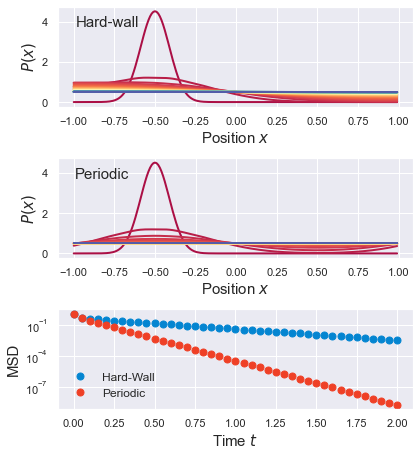

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6.5))
Pal = sns.color_palette("Spectral", len(density_tracker_hw))

msd_hw = []
msd_per = []

for i, (dens_hw, dens_per) in enumerate(zip(density_tracker_hw, density_tracker_per)):
    ax[0].plot(x_array, dens_hw, color=Pal[i], linewidth=2.0)
    ax[1].plot(x_array, dens_per, color=Pal[i], linewidth=2.0)

    msd_hw.append(np.std(dens_hw))
    msd_per.append(np.std(dens_per))

ax[2].plot(time_tracker, msd_hw, 'o', color=sns.xkcd_rgb["cerulean"], markersize=7, label="Hard-Wall")
ax[2].plot(time_tracker, msd_per, 'o', color=sns.xkcd_rgb["tomato"], markersize=7, label="Periodic")

ax[2].set_yscale('log')
ax[2].set_xlabel(r"Time $t$", fontsize=15)
ax[2].set_ylabel(r"MSD", fontsize=15)
ax[1].set_xlabel(r"Position $x$", fontsize=15)
ax[1].set_ylabel(r"$P(x)$", fontsize=15)
ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[0].set_ylabel(r"$P(x)$", fontsize=15)

ax[0].annotate(r"Hard-wall", xy=(0.05,0.8), xycoords="axes fraction", fontsize=15)
ax[1].annotate(r"Periodic", xy=(0.05,0.8), xycoords="axes fraction", fontsize=15)
ax[2].legend(fontsize=12, frameon=False)

plt.tight_layout()
plt.show()

Here, you can see that the MSD of the periodic boundary conditions decays (on a log-y scale) at a faster rate than the hard-wall conditions, as we would expect.

Now, we want to look at the dynamics of the diffusion. We know that the variance of the distribution should get larger at a rate of 

$$ \sigma^2 = 2 D t $$

(so long as there is no interference from boundary conditions) So, if we track the variance over time for a system initialized on a large enough domain, we should be able to see this scaling relationship.

To test this, we initialize a thin Gaussian distribution on a much larger domain (which will make the calculation slower as the diffusion matric will be much larger) and then observe the variance of the time-evolving distribution

In [11]:
x_array_large = np.arange(-5, 5, dx)
init_var = 1/ 128

fpe_diff = Integrator.FPE_Integrator_1D(D, dt, dx, x_array_large, boundaryCond='open')



Initializing diffusion term integration matrix...

		Using Crank-Nicolson integration scheme...
		Initializing integration matrices for diffusion

		Sparse matrix methods preferred...


In [12]:
fpe_diff.initializeProbability(0, init_var)
total_time = 2.0
time = 0
counter += 1

time_tracker = [time]
density_tracker_diff = [fpe_diff.get_prob]

while time <= total_time:
    fpe_diff.diffusionUpdate()
    time += fpe_diff.dt
    counter += 1

    if counter % 5 == 0:
        density_tracker_diff.append(fpe_diff.get_prob)
        time_tracker.append(time)



Text(0, 0.5, '$P(x)$')

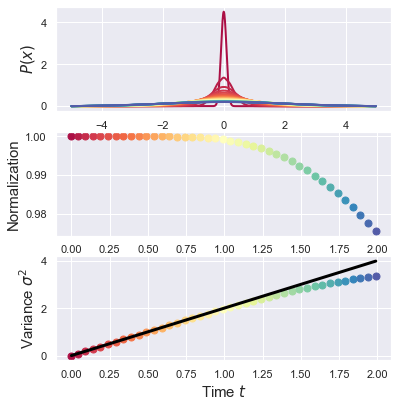

In [13]:
def _get_variance(density, x_vals):
    dx = x_vals[1] - x_vals[0]
    mean = np.sum(x_vals * density * dx)
    var = np.sum(((x_vals - mean) ** 2) * density * dx)
    return var

theory_time = np.arange(0, 2, 0.01)
theory_var = init_var * 1 + (2 * D  * theory_time)

fig, ax = plt.subplots(3, 1, figsize=(6, 6.5))

Pal = sns.color_palette("Spectral", len(density_tracker_diff))

for i, density in enumerate(density_tracker_diff):
    ax[0].plot(x_array_large, density, color=Pal[i], linewidth=2.0)
    ax[1].plot(time_tracker[i], np.sum(density * fpe_diff.dx), 'o', markersize=7, color=Pal[i])
    ax[2].plot(time_tracker[i], _get_variance(density, fpe_diff.xArray), 'o', markersize=7, color=Pal[i])
ax[2].plot(theory_time, theory_var, color=sns.xkcd_rgb["black"], linewidth=3.0)

ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[1].set_xlabel(r"Time $t$", fontsize=15)
ax[2].set_xlabel(r"Time $t$", fontsize=15)
ax[2].set_ylabel(r"Variance $\sigma^2$", fontsize=15)
ax[1].set_ylabel(r"Normalization", fontsize=15)
ax[0].set_ylabel(r"$P(x)$", fontsize=15)

As required, th diffusive dynamics match the predicted relationship exactly over the first $\Delta t \sim 1$, before the distriubution begins permeating the bounray (indicated by the dropoff in normalization).  Importantly, however, this confirms that our dynamics matches expectations

Before moving on, we will briefly explore some of the aspects of the specifics of the diffusion integrator that are worth knowing. 